https://www.kaggle.com/code/sanabdriss/nlp-extract-skills-from-job-Job_descriptions

This project consists of finding a correlation between job descriptions and skills.

In [ ]:
# pip install numpy pandas sklearn wordcloud textblob

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, json file I/O (e.g. pd.read_json)
import string
import nltk
from nltk.corpus import stopwords
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from wordcloud import WordCloud

import matplotlib.pyplot as plt
%matplotlib inline
from textblob import Word

import os
for dirname, _, filenames in os.walk('/input/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [74]:
test = pd.read_csv('data-jobs-20221101.csv')
## Delete empty rows (In case I missed parsing a row)
test = test.dropna()
print("\n ** raw data **\n")
print(test.head())
print("\n ** data shape **\n")
print(test.shape)


 ** raw data **

               company                                          job_title  \
0     MATRIX Resources               Database Administrator - 100% REMOTE   
1               Kforce                      Identity Access Administrator   
2     Volto Consulting                         Identity Access Management   
4               V2soft                     Identity and Access Management   
5  Wilks Brothers, LLC  Identity and Access Management (IAM) Administr...   

           title                                   salary post_date  \
0  administrator             $57K - $87K (Glassdoor est.)       24h   
1  administrator             $43K - $61K (Glassdoor est.)      30d+   
2  administrator  $50.00 - $60.00 Per Hour(Employer est.)        6d   
4  administrator  $50.00 - $55.00 Per Hour(Employer est.)       13d   
5  administrator             $48K - $76K (Glassdoor est.)      30d+   

                                         description  
0  SQL Server Database Administrator 

There are 235 jobs across 5 columns of data.

Clean the job titles.

<AxesSubplot: >

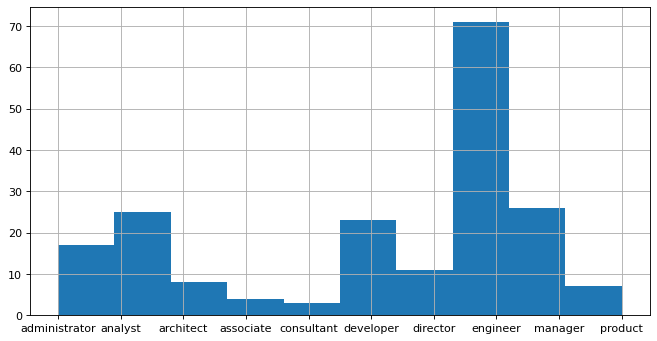

In [53]:
fig=plt.figure(figsize=(10, 5), dpi= 80, facecolor='w', edgecolor='k')
test.title.hist()

Preprocess text data
Since the data we're now working with is at its rawest form, we need to preprocess it before extracting information from it.

in this step, we will:

Convert all text to lower cases
Delete all tabulation,spaces, and new lines
Delete all numericals
Delete nltk's defined stop words
Lemmatize text

In [75]:
## Lower case
test['description'] = test['description'].apply(lambda x: " ".join(x.lower()for x in x.split()))
## remove tabulation and punctuation
test['description'] = test['description'].str.replace('[^\w\s]',' ', regex=True)
## digits
test['description'] = test['description'].str.replace('\d+', ' ', regex=True)

#remove stop words
stop = stopwords.words('english')
other_stop_words = ['junior', 'senior','experience','etc','job','work','company','technique',
                    'candidate','skill','skills','language','menu','inc','new','plus','years',
                   'technology','organization','ceo','cto','account','manager','data','scientist','mobile',
                    'developer','product','revenue','strong', 'team', 'lumen', 'will', 'benefit']

test['description'] = test['description'].apply(lambda x: " ".join(x for x in x.split() if x not in other_stop_words))

## lemmatization
test['description'] = test['description'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))

print("Preprocessed data: \n")
print(test.head())


Preprocessed data: 

               company                                          job_title  \
0     MATRIX Resources               Database Administrator - 100% REMOTE   
1               Kforce                      Identity Access Administrator   
2     Volto Consulting                         Identity Access Management   
4               V2soft                     Identity and Access Management   
5  Wilks Brothers, LLC  Identity and Access Management (IAM) Administr...   

           title                                   salary post_date  \
0  administrator             $57K - $87K (Glassdoor est.)       24h   
1  administrator             $43K - $61K (Glassdoor est.)      30d+   
2  administrator  $50.00 - $60.00 Per Hour(Employer est.)        6d   
4  administrator  $50.00 - $55.00 Per Hour(Employer est.)       13d   
5  administrator             $48K - $76K (Glassdoor est.)      30d+   

                                         description  
0  sql server database administrat

Visualize data
In this step, we will aggregate our data by job titles in order to visualy detect the most frequent words for each job.

In [62]:
## jda stands for job description aggregated
jda = test.groupby(['title']).sum().reset_index()
print("Aggregated job descriptions: \n")
print(jda)

Aggregated job descriptions: 

           title                                            company  \
0  administrator  MATRIX ResourcesKforceVolto ConsultingV2softWi...   
1        analyst  CTGPreferred Mutual Insurance CompanyGovCIOCor...   
2      architect  Federal Reserve Bank of RichmondBlizzard Enter...   
3      associate  Bank of AmericaActive Cyber, LLCGrant Thornton...   
4     consultant                                 DeloitteLumenLumen   
5      developer  IBMManTech International CorporationContinenta...   
6       director  KemperParkland Health and Hospital SystemGrain...   
7       engineer  LululemonStrategic Software SolutionsAmazon.co...   
8        manager  The Home DepotFreddie MacCruiseBayview Asset M...   
9        product  RegionsAllstateAllSTEM ConnectionsAlcor Soluti...   

                                           job_title  \
0  Database Administrator - 100% REMOTEIdentity A...   
1  Access Provisioning AnalystAssoc. Identity & A...   
2  IAM and Security


*** administrator ***



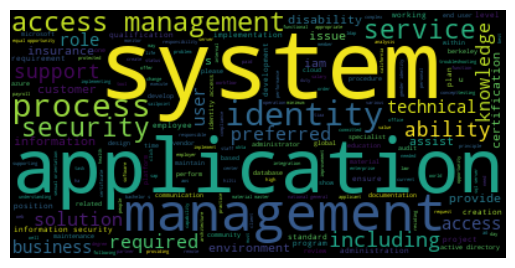


*** analyst ***



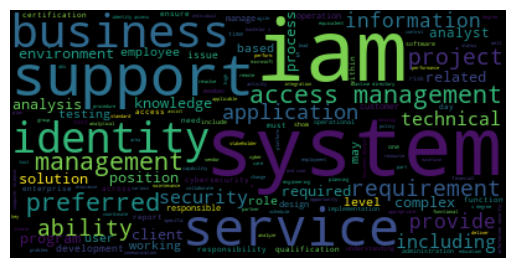


*** architect ***



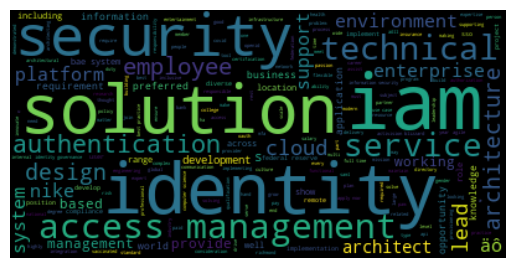


*** associate ***



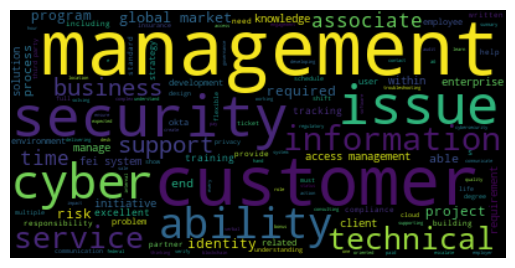


*** consultant ***



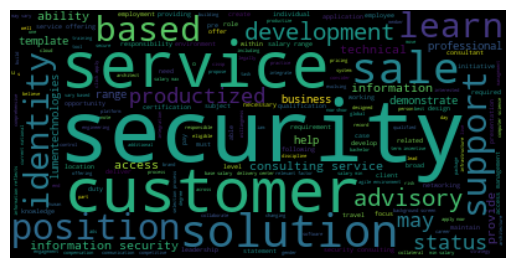


*** developer ***



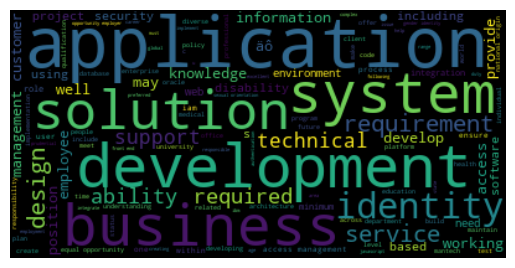


*** director ***



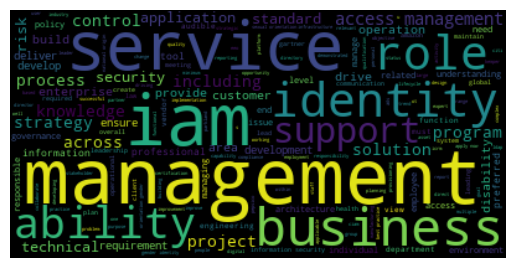


*** engineer ***



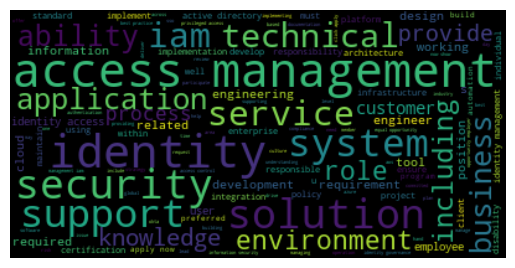


*** manager ***



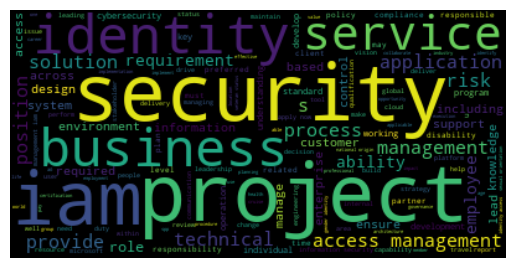


*** product ***



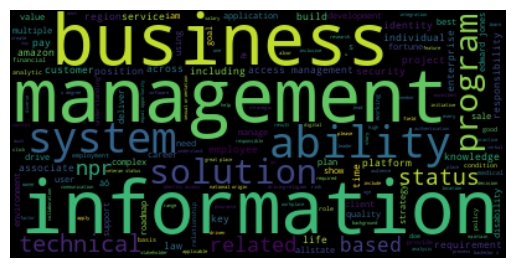

In [63]:
## Visualize data
jobs_list = jda.title.unique().tolist()
for job in jobs_list:

    # Start with one review:
    text = jda[jda.title == job].iloc[0].description
    # Create and generate a word cloud image:
    wordcloud = WordCloud().generate(text)
    print("\n***",job,"***\n")
    # Display the generated image:
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()


In [ ]:
# remove other stop words

other_stop_words = ['junior', 'senior','experience','etc','job','work','company','technique',
                    'candidate','skill','skills','language','menu','inc','new','plus','years',
                   'technology','organization','ceo','cto','account','manager','data','scientist','mobile',
                    'developer','product','revenue','strong']

test['description'] = test['description'].apply(lambda x: " ".join(x for x in x.split() if x not in other_stop_words))

We are now going to translate this skill-extraction problem into a classification one first. And then extract the most important features from each class.

The most important features, in this case, represent the words that most likely will belong to a class ( in our case job title)

I chose for this exercise to train the naive bayes algorithm.

In [64]:
## Converting text to features 
vectorizer = TfidfVectorizer()
#Tokenize and build vocabulary
X = vectorizer.fit_transform(test.description)
y = test.title

# split data into 80% training and 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=109) 
print("train data shape: ",X_train.shape)
print("test data shape: ",X_test.shape)

# Fit model
clf = MultinomialNB()
clf.fit(X_train, y_train)
## Predict
y_predicted = clf.predict(X_test)

train data shape:  (156, 6164)
test data shape:  (39, 6164)


<AxesSubplot: >

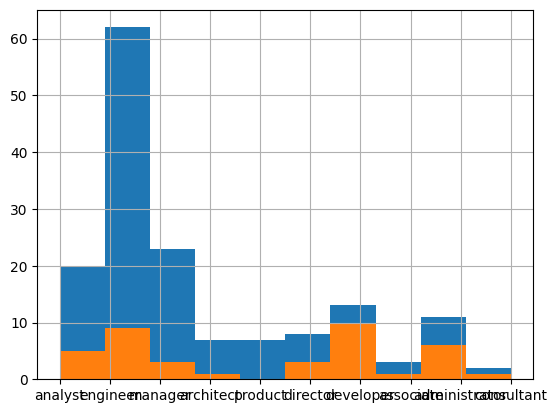

In [67]:
y_train.hist()
y_test.hist()

In [68]:
#evaluate the predictions
print("Accuracy score is: ",accuracy_score(y_test, y_predicted))
print("Classes: (to help read Confusion Matrix)\n", clf.classes_)
print("Confusion Matrix: ")

print(confusion_matrix(y_test, y_predicted))
print("Classification Report: ")
print(classification_report(y_test, y_predicted))

Accuracy score is:  0.23076923076923078
Classes: (to help read Confusion Matrix)
 ['administrator' 'analyst' 'architect' 'associate' 'consultant'
 'developer' 'director' 'engineer' 'manager' 'product']
Confusion Matrix: 
[[ 0  0  0  0  0  0  0  6  0]
 [ 0  0  0  0  0  0  0  5  0]
 [ 0  0  0  0  0  0  0  1  0]
 [ 0  0  0  0  0  0  0  1  0]
 [ 0  0  0  0  0  0  0  1  0]
 [ 0  0  0  0  0  0  0 10  0]
 [ 0  0  0  0  0  0  0  3  0]
 [ 0  0  0  0  0  0  0  9  0]
 [ 0  0  0  0  0  0  0  3  0]]
Classification Report: 
               precision    recall  f1-score   support

administrator       0.00      0.00      0.00         6
      analyst       0.00      0.00      0.00         5
    architect       0.00      0.00      0.00         1
    associate       0.00      0.00      0.00         1
   consultant       0.00      0.00      0.00         1
    developer       0.00      0.00      0.00        10
     director       0.00      0.00      0.00         3
     engineer       0.23      1.00      0.3

/Users/kenmye/Library/Python/3.8/lib/python/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/kenmye/Library/Python/3.8/lib/python/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/kenmye/Library/Python/3.8/lib/python/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


At this step, we have for each class/job a list of the most representative words/tokens found in job descriptions.

Let's shrink this list of words to only:

6 technical skills
6 adjectives
To do so, we use the library TextBlob to identify adjectives.

Also, given a (non-exhaustive) list of programming languages, we can extract the top technical skills.

In [73]:
from textblob import TextBlob
technical_skills = ['python', 'c','r', 'c++','java','hadoop','scala','flask','pandas','spark','scikit-learn','numpy','php','sql','mysql','css','mongdb','nltk','fastai' , 'keras', 'pytorch','tensorflow','linux','Ruby','JavaScript','django','react','reactjs','ai','ui','tableau', 'directory', 'virtual directory', 'radiant logic', 'sailpoint', 'identity proofing', 'identity aggregations', 'identity lifecycle management', 'deprovisioning', 'account management', 'entitlements', 'attribute management', 'reconciliation', 'resolution', 'identity management', 'ldap','active directory', 'azure active directory', 'ad', 'aad', 'mim', 'microsoft identity manager', 'access reviews', 'identity governance and administration', 'identity governance', 'iga', 'recertification', 'identity management', 'entrust', 'venafi', 'one time pin', 'otp' 'FIDO', 'pki', 'enrollment', 'credential management', 'password', 'push notification', 'okta', 'ping', 'single sign-on', 'SSO', 'public key infrastructure', 'authentication', 'authorization', 'access management', 'abac', 'access control', 'saml', 'oidc', 'open id connect', 'active directory federation services', 'adfs', 'policy decision point', 'two-factor authentication', 'tfa', 'mfa', 'multifactor authentication', 'privileged access management', 'pam', 'cyberark', 'beyondtrust', 'thycotic',  'privileged account management', 'policy alignment', 'authentication broker', 'attribute exchange', 'trust framework', 'assertion service', 'federation assertion', 'saml', 'oidc', 'open id connect', 'security token service', 'sts', 
'trust relationship', 'azure', 'aws']
feature_array = vectorizer.get_feature_names()
# number of overall model features
features_numbers = len(feature_array)
## max sorted features number
n_max = int(features_numbers * 0.1)

##initialize output dataframe
output = pd.DataFrame()
for i in range(0,len(clf.classes_)):
    print("\n****" ,clf.classes_[i],"****\n")
    class_prob_indices_sorted = clf.feature_log_prob_[i, :].argsort()[::-1]
    raw_skills = np.take(feature_array, class_prob_indices_sorted[:n_max])
    print("list of unprocessed skills :")
    print(raw_skills)
    
    ## Extract technical skills
    top_technical_skills= list(set(technical_skills).intersection(raw_skills))[:6]
    #print("Top technical skills",top_technical_skills)
    
    ## Extract adjectives
    
    # Delete technical skills from raw skills list
    ## At this steps, raw skills list doesnt contain the technical skills
    #raw_skills = [x for x in raw_skills if x not in top_technical_skills]
    #raw_skills = list(set(raw_skills) - set(top_technical_skills))

    # transform list to string
    txt = " ".join(raw_skills)
    blob = TextBlob(txt)
    #top 6 adjective
    top_adjectives = [w for (w, pos) in TextBlob(txt).pos_tags if pos.startswith("JJ")][:6]
    #print("Top 6 adjectives: ",top_adjectives)
    
    output = output.append({'title':clf.classes_[i],
                        'technical_skills':top_technical_skills,
                        'soft_skills':top_adjectives },
                       ignore_index=True)

/Users/kenmye/Library/Python/3.8/lib/python/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/var/folders/1q/13518n1s1n75fzdx64wlyz5w0000gn/T/ipykernel_28994/1150845976.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append({'title':clf.classes_[i],
/var/folders/1q/13518n1s1n75fzdx64wlyz5w0000gn/T/ipykernel_28994/1150845976.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append({'title':clf.classes_[i],



**** administrator ****

list of unprocessed skills :
['and' 'to' 'of' 'the' 'in' 'with' 'access' 'for' 'security' 'user'
 'management' 'or' 'payroll' 'system' 'application' 'administration'
 'preferred' 'server' 'you' 'database' 'including' 'assist' 'tiaa'
 'insurance' 'all' 'azure' 'general' 'is' 'audit' 'active' 'hour'
 'residing' 'our' 'support' 'process' 'are' 'apm' 'knowledge' 'end'
 'required' 'ibm' 'citizen' 'iam' 'ensure' 'we' 'specialist' 'directory'
 'peraton' 'project' 'implementation' 'information' 'remote' 'service'
 'card' 'your' 'workflow' 'working' 'gcp' 'computer' 'solution' 'role'
 'rohit' 'justin' 'certificate' 'creation' 'identity' 'usmc' 'cloud' 'ad'
 'concept' 'procedure' 'ability' 'implementing' 'administrator'
 'troubleshooting' 'it' 'request' 'various' 'ead' 'aws' 'other' 'please'
 'on' 'plan' 'business' 'per' 'integration' 'national' 'location'
 'applicant' 'okta' 'day' 'duty' 'microsoft' 'match' 'employee' 'that'
 'sql' 'phone' 'have' 'oam' 'review' 'update

/var/folders/1q/13518n1s1n75fzdx64wlyz5w0000gn/T/ipykernel_28994/1150845976.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append({'title':clf.classes_[i],
/var/folders/1q/13518n1s1n75fzdx64wlyz5w0000gn/T/ipykernel_28994/1150845976.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append({'title':clf.classes_[i],



**** associate ****

list of unprocessed skills :
['and' 'to' 'of' 'the' 'market' 'fei' 'global' 'in' 'issue' 'customer'
 'management' 'we' 'tracking' 'with' 'have' 'able' 'end' 'or' 'third'
 'party' 'ticket' 'okta' 'initiative' 'support' 'technical' 'manage'
 'associate' 'be' 'time' 'for' 'ability' 'sale' 'escalate' 'service'
 'regulatory' 'shift' 'information' 'desk' 'enterprise' 'are' 'routine'
 'risk' 'flexible' 'that' 'consulting' 'process' 'verify' 'on' 'you'
 'training' 'insurance' 'who' 'audit' 'gym' 'security' 'program'
 'building' 'at' 'schedule' 'dhs' 'system' 'roadmaps' 'excellent' 'bonus'
 'compliance' 'requirement' 'referral' 'from' 'is' 'cyber' 'am' 'partner'
 'influence' 'oversight' 'required' 'other' 'client' 'oriented' 'access'
 'contact' 'employee' 'all' 'ownership' 'supporting' 'hand' 'communicate'
 'satisfaction' 'our' 'full' 'doing' 'delivering' 'college' 'standard'
 'user' 'troubleshooting' 'must' 'hour' 'understand' 'paid' 'section'
 'every' 'governance' 'inter

/var/folders/1q/13518n1s1n75fzdx64wlyz5w0000gn/T/ipykernel_28994/1150845976.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append({'title':clf.classes_[i],
/var/folders/1q/13518n1s1n75fzdx64wlyz5w0000gn/T/ipykernel_28994/1150845976.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append({'title':clf.classes_[i],



**** developer ****

list of unprocessed skills :
['and' 'to' 'the' 'of' 'in' 'with' 'or' 'for' 'mantech' 'our' 'we'
 'development' 'application' 'is' 'you' 'software' 'that' 'on' 'business'
 'prudential' 'web' 'an' 'are' 'system' 'be' 'ibm' 'your' 'macquarie'
 'deloitte' 'at' 'other' 'solution' 'not' 'service' 'identity' 'design'
 'database' 'it' 'code' 'requirement' 'opportunity' 'test' 'have'
 'management' 'position' 'well' 'may' 'äôs' 'oracle' 'ability' 'employee'
 'information' 'this' 'gdit' 'access' 'rotech' 'people' 'but' 'support'
 'required' 'health' 'using' 'all' 'world' 'project' 'status' 'customer'
 'technical' 'corporate' 'ai' 'authentication' 'based' 'apply' 'knowledge'
 'develop' 'applicant' 'machine' 'any' 'global' 'ml' 'novo' 'nordisk'
 'veteran' 'computer' 'science' 'problem' 'need' 'client' 'from'
 'understanding' 'working' 'quality' 'cfc' 'such' 'server' 'disability'
 'offer' 'include' 'office' 'export' 'if' 'financial' 'iam' 'montclair'
 'about' 'json' 'variety' '

/var/folders/1q/13518n1s1n75fzdx64wlyz5w0000gn/T/ipykernel_28994/1150845976.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append({'title':clf.classes_[i],



**** engineer ****

list of unprocessed skills :
['and' 'to' 'the' 'of' 'in' 'with' 'identity' 'for' 'management' 'access'
 'or' 'iam' 'our' 'security' 'we' 'on' 'is' 'solution' 'engineer' 'be'
 'system' 'you' 'support' 'an' 'directory' 'application' 'that' 'this'
 'service' 'business' 'design' 'are' 'azure' 'technical' 'knowledge'
 'environment' 'information' 'engineering' 'role' 'development' 'your'
 'ability' 'including' 'position' 'it' 'working' 'other' 'all' 'platform'
 'cloud' 'privileged' 'governance' 'customer' 'apply' 'by' 'active'
 'required' 'at' 'requirement' 'opportunity' 'provide' 'process' 'control'
 'remote' 'tool' 'client' 'automation' 'authentication' 'related' 'have'
 'user' 'sailpoint' 'based' 'life' 'best' 'risk' 'enterprise' 'amazon'
 'insurance' 'individual' 'now' 'disability' 'implementation' 'time'
 'area' 'status' 'architecture' 'employee' 'more' 'such' 'policy' 'aws'
 'must' 'certification' 'integration' 'oracle' 'within' 'administration'
 'develop' 'respons

/var/folders/1q/13518n1s1n75fzdx64wlyz5w0000gn/T/ipykernel_28994/1150845976.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append({'title':clf.classes_[i],
/var/folders/1q/13518n1s1n75fzdx64wlyz5w0000gn/T/ipykernel_28994/1150845976.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append({'title':clf.classes_[i],



**** manager ****

list of unprocessed skills :
['and' 'to' 'the' 'of' 'in' 'iam' 'with' 'for' 'or' 'management' 'our'
 'security' 'we' 'access' 'is' 'identity' 'business' 'on' 'you' 'that'
 'are' 'solution' 'risk' 'process' 'be' 'project' 'information'
 'cybersecurity' 'this' 'all' 'service' 'technical' 'an' 'it' 'client'
 'control' 'lead' 'employee' 'sap' 'lincoln' 'position' 'report'
 'enterprise' 'by' 'application' 'group' 'ability' 'operation' 'design'
 'other' 'program' 'travel' 'requirement' 'cruise' 'delivery' 'role'
 'required' 'at' 'compliance' 'knowledge' 'status' 'provide' 'across'
 'system' 'opportunity' 'capital' 'apply' 'any' 'citi' 'standard'
 'support' 'based' 'individual' 'execution' 'ensure' 'qualification'
 'including' 'capability' 'spp' 'employment' 'leadership' 'develop'
 'cyber' 'not' 'understanding' 'essential' 'united' 'key' 'tiktok' 'one'
 'from' 'preferred' 'manage' 'must' 'direct' 'managing' 'more'
 'certification' 'partner' 'customer' 'grc' 'plan' 'review'

/var/folders/1q/13518n1s1n75fzdx64wlyz5w0000gn/T/ipykernel_28994/1150845976.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append({'title':clf.classes_[i],


In [71]:
print(output.T)

                                                                  0  \
title                                                 administrator   
technical_skills                                                 []   
soft_skills       [active, knowledge, ibm, specialist, directory...   

                                                                  1  \
title                                                       analyst   
technical_skills                                                 []   
soft_skills       [preferred, iam, complex, user, responsible, c...   

                                                                2  \
title                                                   architect   
technical_skills                                               []   
soft_skills       [architect, bae, paul, enterprise, poc, remote]   

                                                                  3  \
title                                                     associate   
technical_s